## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [4]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

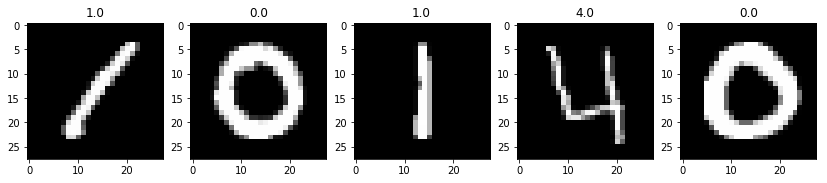

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [6]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [7]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [8]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [9]:
train_g.shape

(42000, 28, 28)

In [10]:
#функция для разделения исходного изображения на 4 части
def split_to_4(ary):
    ny, nx = ary.shape
    sub1 = ary[0:(ny//2), 0:(nx//2)]
    sub2 = ary[0:(ny//2), (nx//2):nx]
    sub3 = ary[(ny//2):ny, 0:(nx//2)]
    sub4 = ary[(ny//2):ny, (nx//2):nx]
    return [sub1, sub2, sub3, sub4]

In [11]:
train_g_split = np.array([split_to_4(ary) for ary in train_g])

In [12]:
train_theta_split = np.array([split_to_4(ary) for ary in train_theta])

In [14]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

In [15]:
test_g_split = np.array([split_to_4(ary) for ary in test_g])
test_theta_split = np.array([split_to_4(ary) for ary in test_theta])

## Вычисляем гистограммы градиентов

In [17]:
n_bins=10 #количество бинов гистограмм для "четвертинок" изображений

In [18]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 4*n_bins))
for i in range(len(train_img)):
    hist = np.ndarray(0)
    for j in range(4):
        dum_hist, borders = np.histogram(train_theta_split[i,j],
                                 bins=n_bins,
                                 range=(0., 2. * np.pi),
                                 weights=train_g_split[i,j])
        hist = np.append(hist, dum_hist)
    train_hist[i] = hist

In [19]:
test_hist = np.zeros((len(test_img), 4*n_bins))
for i in range(len(test_img)):
    hist = np.ndarray(0)
    for j in range(4):
        dum_hist, borders = np.histogram(test_theta_split[i,j],
                                 bins=n_bins,
                                 range=(0., 2. * np.pi),
                                 weights=test_g_split[i,j])
        hist = np.append(hist, dum_hist)
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [20]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [21]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [22]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2, random_state=42)

## Создаем модель для классификации

In [23]:
import pandas as pd

In [24]:
X_train=pd.DataFrame(x_train)

In [25]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.538181,0.080187,0.020880,0.000000,0.001259,0.338984,0.009245,0.000000,0.000000,0.000000,...,0.058227,0.146361,0.005095,0.000000,0.000000,0.191863,0.443347,0.000000,0.020837,0.022023
1,0.130835,0.147047,0.023956,0.000000,0.049981,0.049130,0.037354,0.000000,0.006270,0.154659,...,0.081773,0.066851,0.015687,0.057788,0.305130,0.059345,0.100525,0.122242,0.021368,0.011504
2,0.083755,0.339791,0.418232,0.052509,0.016905,0.000000,0.066183,0.385660,0.041419,0.047524,...,0.078013,0.075194,0.108458,0.158404,0.280901,0.173097,0.175414,0.252047,0.145462,0.150150
3,0.224524,0.317222,0.045674,0.024358,0.025590,0.186292,0.216871,0.001605,0.000000,0.000000,...,0.246117,0.056586,0.028610,0.052927,0.053004,0.426007,0.163417,0.055723,0.072718,0.064431
4,0.037227,0.046527,0.326273,0.000000,0.001280,0.000000,0.000000,0.327590,0.048689,0.035541,...,0.182567,0.000000,0.000000,0.000000,0.013089,0.612378,0.010128,0.001150,0.000000,0.000000


In [26]:
Y_train=pd.DataFrame(y_train, columns=['digit'])

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
cl = RandomForestClassifier().fit(X_train, Y_train)

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [29]:
X_val = pd.DataFrame(x_val)

In [30]:
pred_val = cl.predict(X_val)

## Оцениваем качество решение на валидационной выборке

In [31]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.939523809524


In [32]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[799   0   3   0   4   1   5   2   0   2]
 [  0 893   5   1   2   0   4   4   0   0]
 [  3   5 800  22   1   1   3   2   9   0]
 [  1   1  24 882   0   9   1   7   8   4]
 [  2   3   2   1 782   1  20   4   3  21]
 [  4   0   2  14   6 654   6   2  12   2]
 [ 20   5   1   0   9   6 736   0   7   1]
 [  2   0  23  17   1   1   0 834   2  13]
 [  7   5   7   5   6  18  13   3 759  12]
 [ 14   2   0   4  27   4   4  14  16 753]]


## Предсказания на тестовыйх данных

In [33]:
X_test = pd.DataFrame(test_hist)

In [34]:
pred_test = cl.predict(X_test)

## Визуализируем предсказания

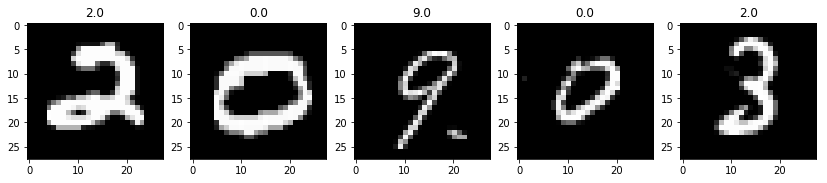

In [35]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [37]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, int(p)))

In [270]:
# Your submission scored 0.94086